In [1]:
import torch
import torchvision
import torch.nn.functional as F
import copy
import matplotlib.pyplot as plt
import time
#device = torch.device("cpu")
"""
A fully-connected ReLU network with one hidden layer, trained to predict y from x
by minimizing squared Euclidean distance.

This implementation defines the model as a custom Module subclass. Whenever you
want a model more complex than a simple sequence of existing Modules you will
need to define your model this way.
"""

class TwoLayerNet(torch.nn.Module):
  def __init__(self, D_in, H, D_out):
    """
    In the constructor we instantiate two nn.Linear modules and assign them as
    member variables.
    """
    super(TwoLayerNet, self).__init__()
    self.linear1 = torch.nn.Linear(D_in, H)
    self.linear2 = torch.nn.Linear(H, D_out)
    
  def forward(self, x):
    """
    In the forward function we accept a Tensor of input data and we must return
    a Tensor of output data. We can use Modules defined in the constructor as
    well as arbitrary (differentiable) operations on Tensors.
    """
    h_relu = F.relu(self.linear1(x))
    y_pred = F.log_softmax( self.linear2(h_relu),dim=1)
    return y_pred




/opt/homebrew/anaconda3/lib/python3.11/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: 'dlopen(/opt/homebrew/anaconda3/lib/python3.11/site-packages/torchvision/image.so, 0x0006): Symbol not found: __ZN3c1017RegisterOperatorsD1Ev
  Referenced from: <CFED5F8E-EC3F-36FD-AAA3-2C6C7F8D3DD9> /opt/homebrew/anaconda3/lib/python3.11/site-packages/torchvision/image.so
  Expected in:     <E459C462-F863-3A5A-AC9F-FD77B14BE845> /opt/homebrew/anaconda3/lib/python3.11/site-packages/torch/lib/libtorch_cpu.dylib'If you don't plan on using image functionality from `torchvision.io`, you can ignore this warning. Otherwise, there might be something wrong with your environment. Did you have `libjpeg` or `libpng` installed before building `torchvision` from source?
  warn(


In [2]:
# Loading train and test dataset
batch_size_train = 64
batch_size_test = 1000
train_loader = torch.utils.data.DataLoader(
  torchvision.datasets.MNIST('data/', train=True, download=True,
                             transform=torchvision.transforms.Compose([
                               torchvision.transforms.ToTensor(),
                               torchvision.transforms.Normalize(
                                 (0.1307,), (0.3081,))
                             ])),
  batch_size=batch_size_train, shuffle=True)

test_loader = torch.utils.data.DataLoader(
  torchvision.datasets.MNIST('data/', train=False, download=True,
                             transform=torchvision.transforms.Compose([
                               torchvision.transforms.ToTensor(),
                               torchvision.transforms.Normalize(
                                 (0.1307,), (0.3081,))
                             ])),
  batch_size=batch_size_test, shuffle=True)

In [3]:
# Get a batch of an  images and corresponding labels from train dataloader
batch_example = next(iter(train_loader))
image_batch_example = batch_example[0]
labels_batch_example = batch_example[1]
image_reshape = image_batch_example.reshape(image_batch_example.shape[0],-1)
# Print the size of the batch of images and labels
print(image_batch_example.shape)
print(labels_batch_example.shape)
print(image_reshape.shape)


torch.Size([64, 1, 28, 28])
torch.Size([64])
torch.Size([64, 784])


In [4]:
vectorized_batch = image_batch_example.reshape(batch_size_train,1*28*28)
input_size = vectorized_batch.shape[-1]
print (input_size)

784


In [5]:
# N is batch size; D_in is input dimension;
# H is hidden dimension; D_out is output dimension.
N, D_in, H, D_out = 64, input_size, 100, 10
log_interval = 10
# Create random Tensors to hold inputs and outputs
#x = torch.randn(N, D_in)
#y = torch.randn(N, D_out)

# Construct our model by instantiating the class defined above.
model = TwoLayerNet(D_in, H, D_out)

In [6]:
def train(model, train_loader, num_epochs, learning_rate):
    model_tr = copy.deepcopy(model)
    model_tr.to(device)
    # Set the model in 'training' mode (ensures all parameters ' gradients are computed it's like setting 'requires_grad=True' for all parameters)
    model_tr.train()
    # Define the optimizer
    optimizer = torch.optim.SGD(model_tr.parameters(), lr=learning_rate)
    # Initialize a list for storing the training loss over epochs 
    train_losses = []
    train_counter = []
    # Training loop
    for epoch in range(1,num_epochs+1):
        # Iterate over batches using the dataloader
        for batch_idx, (images, labels) in enumerate(train_loader):
            images,labels = images.to(device), labels.to(device)
            images = images.reshape(images.shape[0],-1)
            y_pred = model_tr(images)
            loss = F.nll_loss(y_pred, labels)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            if batch_idx % log_interval == 0:
                print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(images), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item()))
                train_losses.append(loss.item())
                train_counter.append((batch_idx*64) + ((epoch-1)*len(train_loader.dataset)))
   
    return model_tr, train_losses, train_counter



In [7]:
def test(model, test_loader):
    model.eval()
    model.to(device)
    test_loss =0
    correct = 0
    test_losses = []
    with torch.no_grad():
        for images, labels in test_loader:
            images,labels = images.to(device), labels.to(device)
            # Get the predicted labels
            images = images.reshape(images.shape[0], -1)
            y_predicted = model(images)
            
            # To get the predicted labels, we need to get the max over all possible classes
            test_loss += F.nll_loss(y_predicted,labels, size_average=False).item()
            #_,labels_predicted = torch.max(y_predicted.data,1) 
            pred = y_predicted.data.max(1, keepdim=True)[1]
            correct += pred.eq(labels.data.view_as(pred)).sum()
            test_loss /= len(test_loader.dataset)
            test_losses.append(test_loss)
    print('\nTest set: Avg. loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
    test_loss, correct, len(test_loader.dataset),100. * correct / len(test_loader.dataset)))
        
    return correct/(len(test_loader.dataset))

In [8]:
# Training with the CPU
device = torch.device("cpu")
num_epochs = 50
learning_rate = 0.01
start_time = time.time()
model_tr, train_losses, train_counter = train(model, train_loader, num_epochs, learning_rate)
end_time = time.time()
training_time = end_time - start_time
print("Total training time : {:.2f} seconds".format(training_time))


Train Epoch: 1 [0/60000 (0%)]	Loss: 2.320417
Train Epoch: 1 [640/60000 (1%)]	Loss: 2.156735
Train Epoch: 1 [1280/60000 (2%)]	Loss: 1.987210
Train Epoch: 1 [1920/60000 (3%)]	Loss: 1.826901
Train Epoch: 1 [2560/60000 (4%)]	Loss: 1.575350
Train Epoch: 1 [3200/60000 (5%)]	Loss: 1.501022
Train Epoch: 1 [3840/60000 (6%)]	Loss: 1.347004
Train Epoch: 1 [4480/60000 (7%)]	Loss: 1.090499
Train Epoch: 1 [5120/60000 (9%)]	Loss: 1.213768
Train Epoch: 1 [5760/60000 (10%)]	Loss: 0.980402
Train Epoch: 1 [6400/60000 (11%)]	Loss: 1.030294
Train Epoch: 1 [7040/60000 (12%)]	Loss: 0.865960
Train Epoch: 1 [7680/60000 (13%)]	Loss: 0.895629
Train Epoch: 1 [8320/60000 (14%)]	Loss: 0.663951
Train Epoch: 1 [8960/60000 (15%)]	Loss: 0.745257
Train Epoch: 1 [9600/60000 (16%)]	Loss: 0.723168
Train Epoch: 1 [10240/60000 (17%)]	Loss: 0.621325
Train Epoch: 1 [10880/60000 (18%)]	Loss: 0.617389
Train Epoch: 1 [11520/60000 (19%)]	Loss: 0.561494
Train Epoch: 1 [12160/60000 (20%)]	Loss: 0.731291
Train Epoch: 1 [12800/60000 (

In [20]:
# Training with the GPU (apple silicon)
device = torch.device("mps")
num_epochs = 50
learning_rate = 0.01
start_time = time.time()
model_tr, train_losses, train_counter = train(model, train_loader, num_epochs, learning_rate)
end_time = time.time()
training_time = end_time - start_time
print("Total training time : {:.2f} seconds".format(training_time))

Train Epoch: 1 [0/60000 (0%)]	Loss: 2.354208
Train Epoch: 1 [640/60000 (1%)]	Loss: 2.180219
Train Epoch: 1 [1280/60000 (2%)]	Loss: 2.033876
Train Epoch: 1 [1920/60000 (3%)]	Loss: 1.904125
Train Epoch: 1 [2560/60000 (4%)]	Loss: 1.773038
Train Epoch: 1 [3200/60000 (5%)]	Loss: 1.593380
Train Epoch: 1 [3840/60000 (6%)]	Loss: 1.522001
Train Epoch: 1 [4480/60000 (7%)]	Loss: 1.372052
Train Epoch: 1 [5120/60000 (9%)]	Loss: 1.237173
Train Epoch: 1 [5760/60000 (10%)]	Loss: 1.196702
Train Epoch: 1 [6400/60000 (11%)]	Loss: 0.988407
Train Epoch: 1 [7040/60000 (12%)]	Loss: 0.922873
Train Epoch: 1 [7680/60000 (13%)]	Loss: 1.031578
Train Epoch: 1 [8320/60000 (14%)]	Loss: 0.890523
Train Epoch: 1 [8960/60000 (15%)]	Loss: 0.897033
Train Epoch: 1 [9600/60000 (16%)]	Loss: 0.759838
Train Epoch: 1 [10240/60000 (17%)]	Loss: 0.758278
Train Epoch: 1 [10880/60000 (18%)]	Loss: 0.755874
Train Epoch: 1 [11520/60000 (19%)]	Loss: 0.745073
Train Epoch: 1 [12160/60000 (20%)]	Loss: 0.720318
Train Epoch: 1 [12800/60000 (

In [23]:
accuracy = test(model_tr,test_loader)


Test set: Avg. loss: 0.0082, Accuracy: 9782/10000 (98%)



Text(0, 0.5, 'negative log likelihood loss')

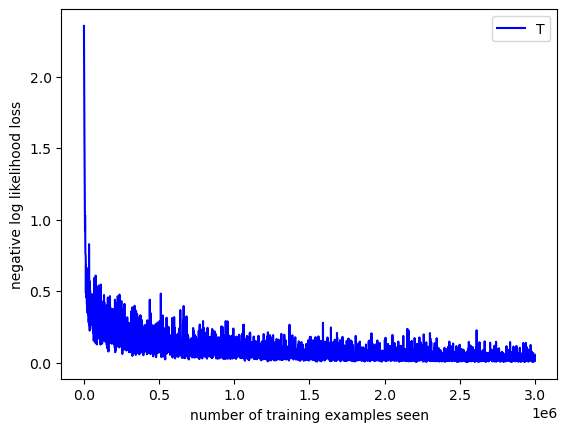

In [24]:
fig = plt.figure()
plt.plot(train_counter, train_losses, color='blue')
plt.legend('Train Loss', loc='upper right')
plt.xlabel('number of training examples seen')
plt.ylabel('negative log likelihood loss')

